In [1]:
import sys
sys.path.append('../../numpy/1D')

from utils import *
from env import *
from model import *
from matplotlib import gridspec

In [2]:
# set directory to folder with model trained with different place field parameter combinations
data_dir = "/Users/mganeshkumar/Library/CloudStorage/OneDrive-HarvardUniversity/Code/online_pf_learning/online/1D/"

(9, 2, 2, 2, 2, 50, 50000)
Contains NaN or 0.0: False


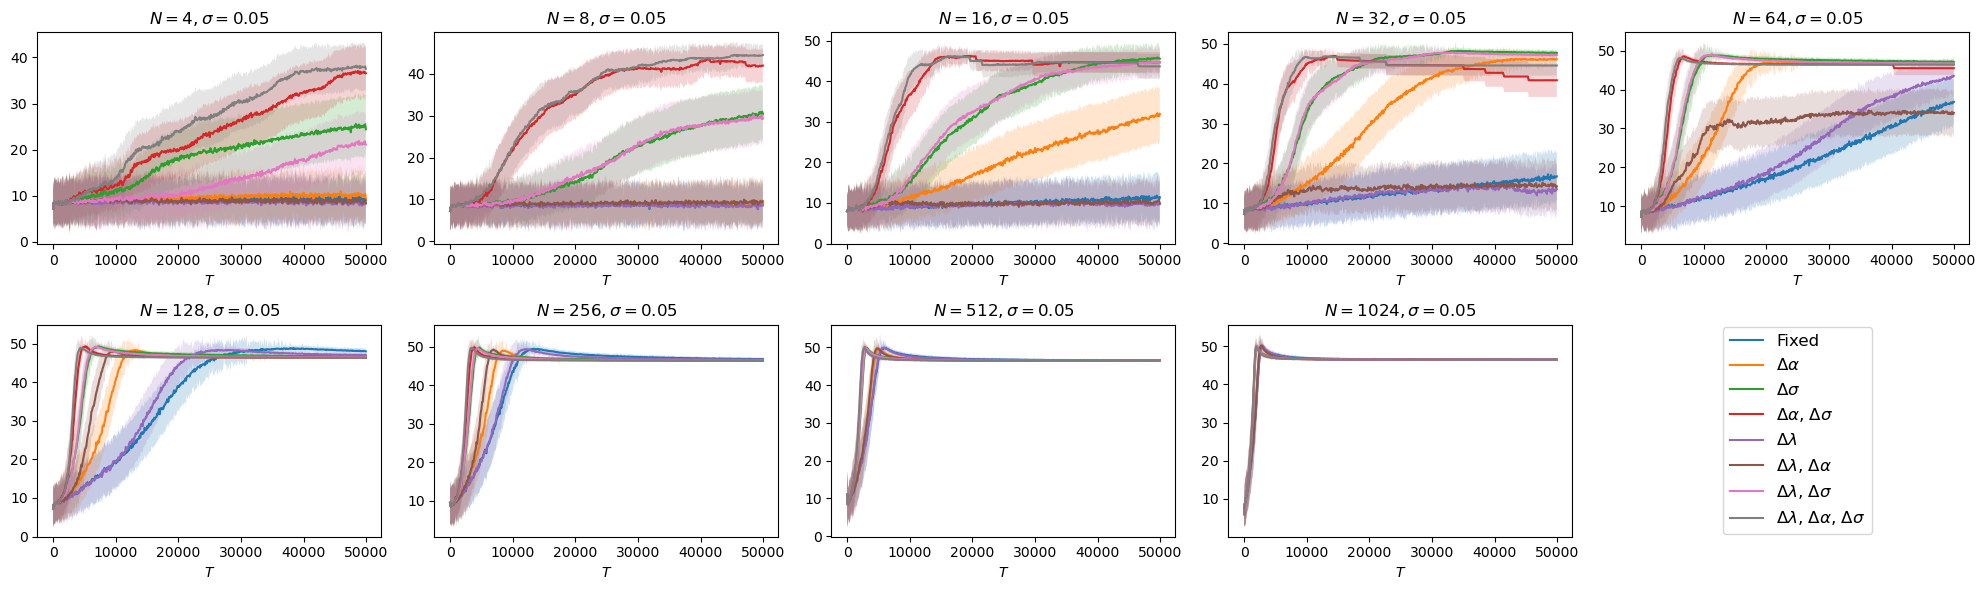

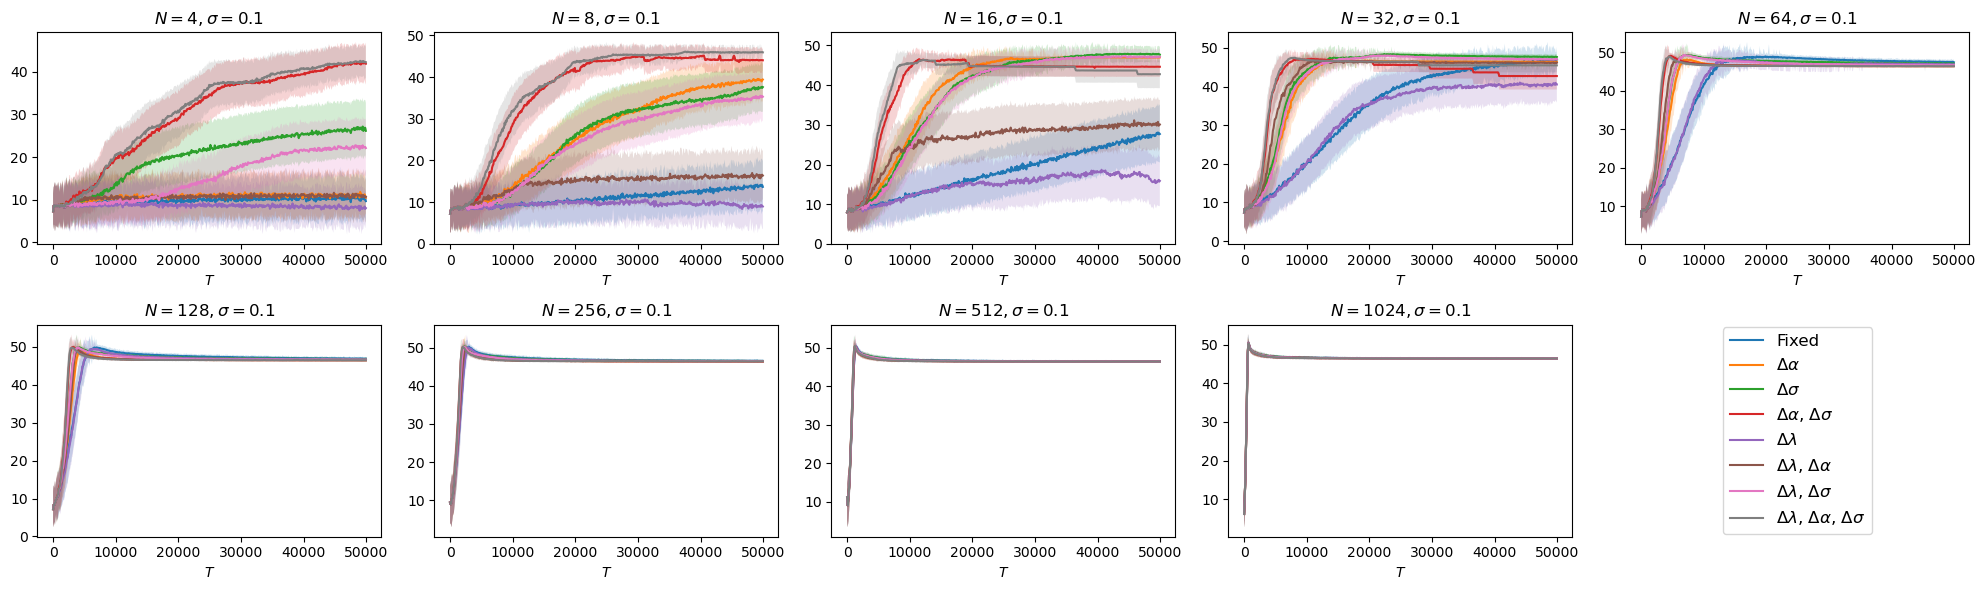

In [3]:
[cum_rewards] = saveload(data_dir+f'/comp_data/field_perf_G_50s_210924', 1, 'load') # field_perf_G_50s_210924, field_perf_lat_G_50000e_30s
print(cum_rewards.shape)

contains_nan_or_zero = np.isnan(cum_rewards).any() or (cum_rewards == 0.0).any()
print("Contains NaN or 0.0:", contains_nan_or_zero) 

downsamp = 100
window = 100
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
ltypes = [0.0, 0.0001]
sigmas = [0.05, 0.1]
npcs = [4,8,16,32,64,128,256,512, 1024]
trials = np.arange(50000)[::downsamp]
for sig,sigma in enumerate(sigmas):
    f,ax = plt.subplots(2,5,figsize=(20,6))
    ax = ax.flatten()
    for n, npc in enumerate(npcs):

        for l,llr in enumerate(ltypes):
            for s,slr in enumerate(ltypes):
                for a,alr in enumerate(ltypes):
                    
                    name_components = []
                    if llr > 0:
                        name_components.append(names_dict['llr'])
                    if alr > 0:
                        name_components.append(names_dict['alr'])
                    if slr > 0:
                        name_components.append(names_dict['slr'])
                    name = ', '.join(name_components) if name_components else 'Fixed'
                    

                    rewards = cum_rewards[n,sig, l,s,a]
                    meang = moving_average(np.mean(rewards,axis=0),window)[::downsamp]
                    cig = 1.96*np.std(rewards,axis=0)[::downsamp]/np.sqrt(50)

                    ax[n].plot(trials, meang,label=name)
                    ax[n].fill_between(trials, meang-cig, meang+cig,alpha=0.2)
                    ax[n].set_xlabel('$T$')
                    ax[n].set_title(f"$N={npc}, \sigma={sigma}$")
                                

            # ax[n].legend(frameon=False, fontsize=8)

    ax[9].axis('off')  # Turn off the axis
    handles, labels = ax[0].get_legend_handles_labels()
    legend_ax = ax[9]
    legend_ax.axis('off')
    legend_ax.legend(handles, labels, loc='center', fontsize=12)

    f.tight_layout()
    # f.savefig(f'./svgs/all_field_perf_{sigma}s.svg')

(2, 2, 2, 50000)
Fixed 27.671808954178655
$\Delta\alpha$ 46.96260844316383
$\Delta\sigma$ 47.64596427521909
$\Delta\alpha$, $\Delta\sigma$ 44.590876438139446
$\Delta\lambda$ 15.8811168967033
$\Delta\lambda$, $\Delta\alpha$ 30.050142513582887
$\Delta\lambda$, $\Delta\sigma$ 47.069853543920644
$\Delta\lambda$, $\Delta\alpha$, $\Delta\sigma$ 42.72287623437037


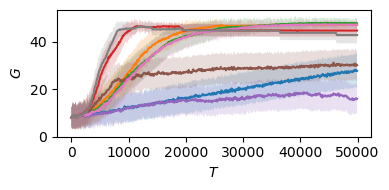

In [4]:
# cum_rewards = np.mean(cum_rewards,axis=5)
window = 100
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
ltypes = [0.0, 0.0001]
sigmas = [0.05, 0.1]
npcs = [4,8,16,32,64,128,256,512, 1024]
downsamp = 100

npc_idx = 2
sigma_idx = 1

trials = np.arange(cum_rewards.shape[-1])[::downsamp]

avgg = cum_rewards[npc_idx, sigma_idx]
meang = np.mean(avgg, axis=3)
cig = 1.96 * np.std(avgg, axis=3)/np.sqrt(avgg.shape[3])


print(meang.shape)

f,ax = plt.subplots(1,1,figsize=(4,2))

for l,llr in enumerate(ltypes):
    for s,slr in enumerate(ltypes):
        for a,alr in enumerate(ltypes):
            
            name_components = []
            if llr > 0:
                name_components.append(names_dict['llr'])
            if alr > 0:
                name_components.append(names_dict['alr'])
            if slr > 0:
                name_components.append(names_dict['slr'])
            name = ', '.join(name_components) if name_components else 'Fixed'


            reward = moving_average(meang[l,s,a],window)[:-1][::downsamp]
            
            stdg = cig[l,s,a][::downsamp]
            
            ax.plot(trials, reward,label=name)
            ax.fill_between(trials, reward - stdg, reward + stdg, alpha=0.2)

            print(name, reward[-1])



ax.set_xlabel('$T$')            
ax.set_ylabel('$G$')      

# # ax[1].set_yscale('log')
# handles, labels = ax[1].get_legend_handles_labels()
# f.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=True, fontsize=8)
# Adjust the layout, ensuring the legend fits within the specified figure size
f.tight_layout(rect=[0, 0.0, 1, 1])

# f.savefig('./svgs/field_G_conv_ind.svg')

In [5]:
def evaluate_convergence(G, threshold=30, window=100):
    rewards = np.array(moving_average(G,window))
    # Calculate convergence speed
    try:
        convergence_epoch = next(i for i, v in enumerate(rewards) if v > threshold)
    except StopIteration:
        convergence_epoch = len(rewards)
    return convergence_epoch

print(cum_rewards.max())
window = 500
ltypes = [0.0, 0.0001]
sigmas = [0.05, 0.1]
npcs = [4,8,16,32,64,128,256,512, 1024]
seeds = 50
threshold = 45 #np.mean(cum_rewards[-1,0,-1,-1,-1])*0.9
print(threshold)
conv_perf = np.zeros([len(npcs),len(sigmas), len(ltypes), len(ltypes), len(ltypes), seeds])

for sig,sigma in enumerate(sigmas):
    for n, npc in enumerate(npcs):
        # threshold = np.max(cum_rewards[n,sig]) * 0.8
        # print(np.max(cum_rewards[n,sig]), threshold)
        for l,llr in enumerate(ltypes):
            for s,slr in enumerate(ltypes):
                for a,alr in enumerate(ltypes):
                    for seed in range(seeds):
                   
                        rewards = cum_rewards[n,sig, l,s,a, seed]
                        conv_perf[n, sig, l,s,a, seed] = evaluate_convergence(rewards, threshold, window)
                        # print(npc, sigma, llr, slr, alr, conv_perf[n,sig,l,s,a])
print(conv_perf.shape)


59.996119428209845
45
(9, 2, 2, 2, 2, 50)


(9, 2, 2, 2)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)
(9,) (9,)


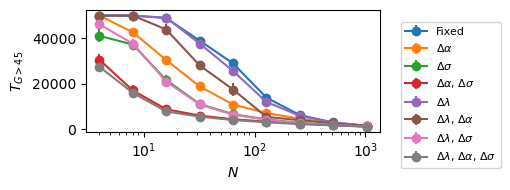

In [6]:
# cum_rewards = np.mean(cum_rewards,axis=5)
window = 100
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
ltypes = [0.0, 0.0001]
sigmas = [0.05, 0.1]
npcs = [4,8,16,32,64,128,256,512, 1024]
downsamp = 100

# sigma_idx = 1
# avg_cp = conv_perf[:,sigma_idx]

avg_cp= np.mean(conv_perf,axis=1)  # average over widths

mean_cp = np.mean(avg_cp, axis=4)
ci_cp = 1.96 * np.std(avg_cp, axis=4)/np.sqrt(avg_cp.shape[4])

print(mean_cp.shape)

f,ax = plt.subplots(1,1,figsize=(4,2))

for l,llr in enumerate(ltypes):
    for s,slr in enumerate(ltypes):
        for a,alr in enumerate(ltypes):
            
            name_components = []
            if llr > 0:
                name_components.append(names_dict['llr'])
            if alr > 0:
                name_components.append(names_dict['alr'])
            if slr > 0:
                name_components.append(names_dict['slr'])
            name = ', '.join(name_components) if name_components else 'Fixed'


            cpm = mean_cp[:,l,s,a]
            cps = ci_cp[:,l,s,a]

            print(cpm.shape, cps.shape)

            ax.errorbar(x=npcs,y=cpm,yerr=cps,label=name, marker='o')
            # ax[1].fill_between(npc, cpm - cps, cpm + cps, alpha=0.2)


ax.set_xlabel('$N$')            
ax.set_ylabel('$T_{G>45}$')      
# ax[1].legend(frameon=False, fontsize=8)
ax.set_xscale('log')

# ax[1].set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=True, fontsize=8)
# Adjust the layout, ensuring the legend fits within the specified figure size
f.tight_layout(rect=[0, 0.0, 1, 1])

# f.savefig('./svgs/field_T_conv_ind.svg')

In [7]:
model_names = []
for l,llr in enumerate(ltypes):
    for s,slr in enumerate(ltypes):
        for a,alr in enumerate(ltypes):
            
            name_components = []
            if llr > 0:
                name_components.append(names_dict['llr'])
            if alr > 0:
                name_components.append(names_dict['alr'])
            if slr > 0:
                name_components.append(names_dict['slr'])
            name = ', '.join(name_components) if name_components else 'Fixed'
            model_names.append(name)

# Assuming data is loaded into times_to_converge and max_accuracies
times_to_converge = np.mean(np.mean(conv_perf,axis=0),axis=0).reshape(8,50)
max_accuracies = np.mean(np.mean(cum_rewards,axis=0),axis=0)[:,:,:,:,-1].reshape(8,50)  # (9, 2, 2, 2, 2, 50, 50000)



In [8]:

from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# Normality check
normality_p_values = [shapiro(model_data).pvalue for model_data in times_to_converge]
print(f'Normality p-values for Time to Converge: {normality_p_values}')

normality_p_values_acc = [shapiro(model_data).pvalue for model_data in max_accuracies]
print(f'Normality p-values for Maximum Accuracy: {normality_p_values_acc}')

# Homogeneity of variances
levene_stat, levene_p = levene(*times_to_converge)
print(f'Levene’s Test for Time to Converge: stat = {levene_stat}, p = {levene_p}')

levene_stat_acc, levene_p_acc = levene(*max_accuracies)
print(f'Levene’s Test for Maximum Accuracy: stat = {levene_stat_acc}, p = {levene_p_acc}')

# Decide between parametric or non-parametric tests
normally_distributed = all(p > 0.05 for p in normality_p_values)
variances_equal = levene_p > 0.05

normally_distributed_acc = all(p > 0.05 for p in normality_p_values_acc)
variances_equal_acc = levene_p_acc > 0.05

# Initialize the matrix
pairwise_matrix_time = np.zeros((8, 8), dtype=float)
pairwise_matrix_acc = np.zeros((8, 8), dtype=float)

# Pairwise comparisons for Time to Converge
for i in range(8):
    for j in range(i + 1, 8):
        if normally_distributed and variances_equal:
            _, p_value = ttest_ind(times_to_converge[i], times_to_converge[j])
        else:
            _, p_value = mannwhitneyu(times_to_converge[i], times_to_converge[j])
        pairwise_matrix_time[i, j] = p_value
        pairwise_matrix_time[j, i] = p_value

# Pairwise comparisons for Maximum Accuracy
for i in range(8):
    for j in range(i + 1, 8):
        if normally_distributed_acc and variances_equal_acc:
            _, p_value = ttest_ind(max_accuracies[i], max_accuracies[j])
        else:
            _, p_value = mannwhitneyu(max_accuracies[i], max_accuracies[j])
        pairwise_matrix_acc[i, j] = p_value
        pairwise_matrix_acc[j, i] = p_value



Normality p-values for Time to Converge: [0.3407638967037201, 0.6704128980636597, 0.7803835272789001, 0.12288902699947357, 0.4658549726009369, 0.0002385843254160136, 0.8727681636810303, 0.9878479242324829]
Normality p-values for Maximum Accuracy: [0.5415323972702026, 0.0923655703663826, 0.0100755225867033, 4.9396894610254094e-05, 0.12821635603904724, 0.09399259090423584, 0.2653019428253174, 7.2551997618575115e-06]
Levene’s Test for Time to Converge: stat = 5.106638631202944, p = 1.4336479042481128e-05
Levene’s Test for Maximum Accuracy: stat = 4.117499131857003, p = 0.00022098661581807264


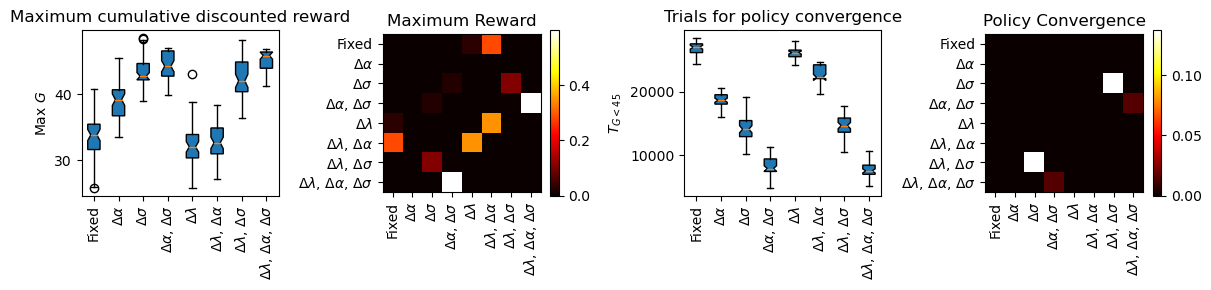

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

ax[2].boxplot(times_to_converge.T, notch=True, patch_artist=True)
ax[2].set_title('Trials for policy convergence')
ax[2].set_ylabel('$T_{G<45}$')
ax[2].set_xticks(np.arange(1, 9))
ax[2].set_xticklabels(model_names, rotation=90)

ax[0].boxplot(max_accuracies.T, notch=True, patch_artist=True)
ax[0].set_title('Maximum cumulative discounted reward')
ax[0].set_ylabel('Max $G$')
ax[0].set_xticks(np.arange(1, 9))
ax[0].set_xticklabels(model_names, rotation=90)

im0 = ax[3].imshow(pairwise_matrix_time, cmap='hot', interpolation='none')
fig.colorbar(im0, ax=ax[3])
ax[3].set_xticks(np.arange(8))
ax[3].set_yticks(np.arange(8))
ax[3].set_xticklabels(model_names, rotation=90)
ax[3].set_yticklabels(model_names)
ax[3].set_title('Policy Convergence')

im1 = ax[1].imshow(pairwise_matrix_acc, cmap='hot', interpolation='none')
fig.colorbar(im1, ax=ax[1])
ax[1].set_xticks(np.arange(8))
ax[1].set_yticks(np.arange(8))
ax[1].set_xticklabels(model_names, rotation=90)
ax[1].set_yticklabels(model_names)
ax[1].set_title('Maximum Reward')

fig.tight_layout()
plt.show()
# fig.savefig('./svgs/perf_compare_stats.svg')